# US Census Data API/Data Collection
## ACS Survey 5

The ACS Survey 5 contains data from 2019 to 2022 and includes social, economic, demographic, and housing data all the way down to the zip code level. We have decided to use zip code level data for our analysis. We can then split zip codes into urban/suburban/rural and into various household income buckets. We can also summarize across the state.

In [2]:
# Dependencies
import requests
import numpy as np
import pandas as pd
from census import Census
from us import states
from config import census_api_key
import matplotlib.pyplot as plt

## Data Requirements

So, what data will we need to collect? 

For all zip codes in california: 
For the five years we are interested in:
-        What is the population by zip code?
-        What is the geographic area by zip code
-        What is the household income by zip code

It may be worth exploring to see if there are other data that would be helpful for answering some intriguing questions, but this should be enough to cover the questions already identified in our project. We can marry these data with the information on car registration by fuel from the california government website as well as California energy department info on energy production.

At present, I don't have geographic area by zip code. Census does not publish this. They do publish population density, but not by zip code. May need to summarize by county since zip codes are by residence, not technically a geographic area. See the "Alternate Data Sets" section for these results.

In [3]:
# Create an instance of the Census library
# Run Census Search to retrieve data on all zip codes (2018 to 2022 ACS5 Census--latest five years)
# We'll need a for loop to go through the years from 2018 to 2022
# For loops stop just before the last member of the range since it is a zero index system

multi_census_pd = pd.DataFrame()

for year in range(2018, 2023):
    c = Census(
        census_api_key,
        year = year
    )
    census_data = c.acs5.get(
        (
            "NAME",
            "B19013_001E",
            "B01003_001E",
        ),
        {'for': 'zip code tabulation area:*'}
    )

    # Convert to DataFrame
    census_pd = pd.DataFrame(census_data)

    # Column renaming
    census_pd = census_pd.rename(
        columns = {
            "NAME": "Name",
            "B19013_001E": "Household Income",
            "B01003_001E": "Population",
            "zip code tabulation area": "Zipcode"
        }
    )

    # Configure the final DataFrame (basically, just drop the "Name" column)
    census_pd = census_pd[
        [
            "Zipcode",
            "Population",
            "Household Income",
        ]
    ]
    census_pd['Year'] = year

    multi_census_pd = pd.concat([census_pd, multi_census_pd], axis=0)

## Filters/Slices

I will need to filter this dataset down to just show California zip codes and add in their city, longitude, latitude in case
we want to plot something on a map, or in case we want to group by city or something like that. 

In [4]:
# In order to filter by state, we can use a csv file that is available from US census containing all 
# states, cities, zips, and the state_fips abbreviation.

zip_state_pd = pd.read_csv("Resources/geo-data.csv")

# Now, we just need to merge our two dataframes to get just the California values
multi_census_pd = multi_census_pd.merge(zip_state_pd, how='inner', left_on = 'Zipcode', right_on = 'zipcode', copy='false')

In [5]:
# OK, now let's do some cleanup and drop states we don't need...
multi_census_pd.drop(columns='zipcode', inplace=True)
multi_census_pd = multi_census_pd[multi_census_pd['state_abbr'] == 'CA']

## Data Cleansing and Output

I will need to cleanse the data a bit so that I get rid of NaN's and negative income values in the raw census data.


In [6]:
# We need to drop the following rows:
#     1) Any rows where the population is zero (to reduce risk of dividing by zero)
#     2) Any rows where Household Income is negative
#     3) Any rows missing cities (in case we end up agregating by city)
#     4) Any rows missing counties (in case we end up agregating by county)
#     5) Any rows where the city is just a ZCTA (zip code), not an actual city name
#     6) Any rows where the count by zip code is less than 5, so we don't have mismatched data by year
#        --basically situations where maybe there are data for one year for a given zip, but not for another year

multi_census_pd = multi_census_pd[multi_census_pd['Population']!= 0]
multi_census_pd = multi_census_pd[multi_census_pd['Household Income']> 0]
multi_census_pd = multi_census_pd[multi_census_pd['city'].notna()]
multi_census_pd = multi_census_pd[multi_census_pd['county'].notna()]
multi_census_pd = multi_census_pd[multi_census_pd['city'].str.startswith('Zcta') == False]

# To do number 6 above, we need to first make a list of zip codes
# Where the row count is less than five (since we ran this for five years)
keepzip = multi_census_pd.groupby('Zipcode').count()
keepzip = keepzip.loc[keepzip['city'] == 5]
# Now we can delete any rows from multi_census_pd
# Where the Zipcode is not in the 'keepzip' file
multi_census_pd = multi_census_pd[multi_census_pd['Zipcode'].isin(keepzip.index)]

multi_census_pd


,Zipcode,Population,Household Income,Year,state_fips,state,state_abbr,county,city
141887,90001,57652.0,57698.0,2022,6,California,CA,Los Angeles,Los angeles
141888,90001,58245.0,52806.0,2021,6,California,CA,Los Angeles,Los angeles
141889,90001,58974.0,48011.0,2020,6,California,CA,Los Angeles,Los angeles
141890,90001,59832.0,43360.0,2019,6,California,CA,Los Angeles,Los angeles
141891,90001,58975.0,38521.0,2018,6,California,CA,Los Angeles,Los angeles
...,...,...,...,...,...,...,...,...,...
150163,96161,19146.0,113433.0,2022,6,California,CA,Nevada,Truckee
150164,96161,19058.0,107321.0,2021,6,California,CA,Nevada,Truckee
150165,96161,18782.0,100205.0,2020,6,California,CA,Nevada,Truckee
150166,96161,18488.0,98924.0,2019,6,California,CA,Nevada,Truckee


In [7]:
# Now we can write out our data file for incorporation into the master Pandas notebook
multi_census_pd.to_csv("Resources/census_data.csv", header=True, index=False)

## Alternate Data Set (by County rather than Zip since not all data available by Zip)
Not all of the diferent datasets are available by zip code, so I need to prepare a couple different files:
- Census data by county
- A cross reference from zip code to county

In [8]:
# Create an instance of the Census library
# Run Census Search to retrieve data on all counties (2018 to 2022 ACS5 Census--latest five years)
# We'll need a for loop to go through the years from 2018 to 2022
# For: loops stop just before the last member of the range since it is a zero index system
# We'll start by creating an empty dataframe that we will hold all of our data for each year...

multi_census_county = pd.DataFrame()

for year in range(2018, 2023):
    c = Census(
        census_api_key,
        year = year
    )
    census_data = c.acs5.get(
        (
            "NAME",
            "B19013_001E",
            "B01003_001E"
        ),
        {'for': 'county:*', 'in': 'state:06'}
    )


    # Convert to DataFrame
    census_pd = pd.DataFrame(census_data)

    # Column renaming
    census_pd = census_pd.rename(
        columns = {
            "NAME": "Name",
            "B19013_001E": "Household Income",
            "B01003_001E": "Population",
            "county": "County FIPS"
        }
    )


    
    # Configure the final DataFrame (basically, just drop the "Name" column)
    census_pd = census_pd[
        [
            "County FIPS",
            "Population",
            "Household Income",
        ]
    ]
    census_pd['Year'] = year

    multi_census_county = pd.concat([census_pd, multi_census_county], axis=0)


In [9]:
# But our county FIPS does not tell us the name of the county.
# We can pull in a CSV with a FIPS lookup value for California taken from US Census SF1

# We need to make sure the FIPS column isn't interpreted as a number, so we specify the dtype explicitly
county_name_pd = pd.read_csv('Resources/census_county_name_fips.csv', dtype={
    'Name': 'string',
    'FIPS': 'string'
})

In [10]:
# So, now we will join our county name cross reference to our dataset...
multi_census_county = multi_census_county.merge(county_name_pd,
                                                how='inner',
                                                left_on = 'County FIPS',
                                                right_on = 'FIPS',
                                                copy = 'false'
                                               )
# Then, we will do a little cleanup--renaming columns, dropping the FIPS columns, and reordering...
multi_census_county = multi_census_county.rename(columns={"Name": "County"})
multi_census_county.drop('County FIPS', axis=1, inplace=True)
multi_census_county.drop('FIPS', axis=1, inplace=True)
multi_census_county = multi_census_county[['County', 'Year', 'Population', 'Household Income']]

In [11]:
# While this dataset appears to be much cleaner than the ZIP dataset,
# just as a precaution we will run whatever cleanup code still applies
# from our analysis of the ZIP dataset.

multi_census_county = multi_census_county[multi_census_county['Population']!= 0]
multi_census_county = multi_census_county[multi_census_county['Household Income']> 0]
multi_census_county = multi_census_county[multi_census_county['County'].notna()]

multi_census_county

,County,Year,Population,Household Income
0,Alameda,2022,1663823.0,122488.0
1,Alameda,2021,1673133.0,112017.0
2,Alameda,2020,1661584.0,104888.0
3,Alameda,2019,1656754.0,99406.0
4,Alameda,2018,1643700.0,92574.0
...,...,...,...,...
285,Yuba,2022,81705.0,66693.0
286,Yuba,2021,80404.0,62666.0
287,Yuba,2020,77524.0,59424.0
288,Yuba,2019,76360.0,58054.0


In [12]:
# Now we can write our data set to a CSV file for any of the collaborators to use...
multi_census_county.to_csv("Resources/census_data_by_county.csv", header=True, index=False)

In [13]:
# We still need to make a file containing the zip codes and the counties
# so that we can summarize by county in situations where there is no zipcode level information

zipcode_county_pd = multi_census_pd.loc[multi_census_pd['Year'] == 2022]
zipcode_county_pd = zipcode_county_pd[
        [
            "Zipcode",
            "county"
        ]
    ]

In [14]:
# And now we will write out our zip/county cross reference file for anyone who needs it...
zipcode_county_pd.to_csv("Resources/zip_to_county.csv", header=True, index=False)

## Extrapolation
Since not all our datasets are available for the same years, as a team we decided
that we would extrapolate out the census data to the year 2023 in order to come up with the most
recent five year period for analysis. 

In [15]:
# Pseudocode: for the multi_census_county dataframe, we will want to group by the county, grab the 2018 value for each of population and
# household income, grab the 2022 value, find the difference, divide by four (the number of years of change). This will
# be the average yearly change. 
#
# Then we will create a 2023 value of each of population and household income that is the sum of the 2022 value and this delta.

# Using Alameda County as an example, grab the 2022 value of "Population" (1663823), the 2018 value (1643700), find the difference (20123),
# divide by 4, convert to an integer since you can't have fractional people (5031) , And add that value to the 2022 value so we get 
# an extrampolated 2023 population value for Alameda County of 1668854- a slight increase over 2022.
#
# The same can be done for Household income. It has gone (in Alameda) from 92574 in 2018 to 122488 in 2022. That's an increae of 29914 in 4 years.
# So that's an average increase of 7479 per year (integer value again). So we add 7479 to our 2022 number and get 129967 as our 2023 household income.


delta_start = multi_census_county.loc[multi_census_county['Year'] == 2018]
delta_start = delta_start.rename(columns={"Population": "Start Pop",
                                          "Household Income": "Start Income"
                                         })
delta_end = multi_census_county.loc[multi_census_county['Year'] == 2022]
delta_end = delta_end.rename(columns={"Population": "End Pop",
                                          "Household Income": "End Income"
                                       })
delta_start.drop('Year', axis=1, inplace=True)
delta_end.drop('Year', axis=1, inplace=True)
delta = delta_start.merge(delta_end, how='inner', on='County')
delta["Pop Delta"] = round((delta["End Pop"] - delta["Start Pop"]) / 4, 0)
delta["Inc Delta"] = round((delta["End Income"] - delta["Start Income"]) / 4, 0)
delta["Population"] = delta["End Pop"] + delta["Pop Delta"]
delta["Household Income"] = delta["End Income"] + delta["Inc Delta"]
delta.drop(['Start Pop', 'Start Income', 'End Pop', 'End Income', 'Pop Delta', 'Inc Delta'], axis=1, inplace=True)
delta["Year"] = 2023
delta = delta[['County', 'Year', 'Population', 'Household Income']]
census_county_extrapolate = pd.concat([delta, multi_census_county], axis=0)
census_county_extrapolate = census_county_extrapolate.sort_values(by=['County','Year'],ignore_index=True)

## Include Geograpic Area by County

In order to determine whether there are differences in adoption by county, we will need to know the area of each county, then we can calculate population density by dividing population by area.

In [16]:
# First, we import a data file containing the area in square miles for each county

county_area_pd = pd.read_csv("Resources/census_county_area.csv")

# Now, we can merge this with our extrapolated, complete dataset...

census_county_extrapolate = census_county_extrapolate.merge(county_area_pd, how='inner', on='County')
census_county_extrapolate["Density"] = census_county_extrapolate["Population"] / census_county_extrapolate["Area (sq mi)"]

# Time to write out our results...

census_county_extrapolate.to_csv("Resources/census_data_by_county_with_2023.csv", header=True, index=False)

In [17]:
census_county_extrapolate

,County,Year,Population,Household Income,Area (sq mi),Density
0,Alameda,2018,1643700.0,92574.0,737.57,2228.534241
1,Alameda,2019,1656754.0,99406.0,737.57,2246.232900
2,Alameda,2020,1661584.0,104888.0,737.57,2252.781431
3,Alameda,2021,1673133.0,112017.0,737.57,2268.439606
4,Alameda,2022,1663823.0,122488.0,737.57,2255.817075
...,...,...,...,...,...,...
343,Yuba,2019,76360.0,58054.0,630.69,121.073745
344,Yuba,2020,77524.0,59424.0,630.69,122.919342
345,Yuba,2021,80404.0,62666.0,630.69,127.485770
346,Yuba,2022,81705.0,66693.0,630.69,129.548590


## Merge Datasets for Visualizations

Now, we need to bring in data created by other collaborators.  First, we will bring in the DMV data generated by Gina.

In [18]:
# First, we need to import the DMV data into a Pandas dataframe...

battery_electric_df = pd.read_csv('battery_electric_totals.csv')

In [19]:
battery_electric_df.head()

,county,Fuel,Year,Vehicles
0,Alameda,Battery Electric,2020,4340
1,Alameda,Battery Electric,2021,4750
2,Alameda,Battery Electric,2022,5580
3,Alpine,Battery Electric,2020,5
4,Alpine,Battery Electric,2021,15


In [20]:
# Now we can merge those data with the existing census dataframe so that we have
# the combination of County, Year, Population, Income, Pop Density, and number of
# vehicles registered that year

merged_census_DMV = census_county_extrapolate.merge(battery_electric_df,
                                                    how='inner',
                                                    left_on = ['County', 'Year'],
                                                    right_on = ['county', 'Year'],
                                                    copy='false')

# We can drop a couple column that aren't needed. First, we have two county columns, so dropping one
# Second, we don't need to specify the fuel since the only records in the dataframe are EV's
merged_census_DMV.drop('county', axis=1, inplace=True)
merged_census_DMV.drop('Fuel', axis=1, inplace=True)

merged_census_DMV

,County,Year,Population,Household Income,Area (sq mi),Density,Vehicles
0,Alameda,2020,1661584.0,104888.0,737.57,2252.781431,4340
1,Alameda,2021,1673133.0,112017.0,737.57,2268.439606,4750
2,Alameda,2022,1663823.0,122488.0,737.57,2255.817075,5580
3,Alpine,2020,1159.0,85750.0,738.62,1.569142,5
4,Alpine,2021,1344.0,96000.0,738.62,1.819610,15
...,...,...,...,...,...,...,...
163,Yolo,2021,216703.0,78386.0,1013.27,213.865011,615
164,Yolo,2022,217141.0,85097.0,1013.27,214.297275,765
165,Yuba,2020,77524.0,59424.0,630.69,122.919342,150
166,Yuba,2021,80404.0,62666.0,630.69,127.485770,160


In [21]:
# For purposes of determining Urban vs Rural counties, the US Census bureau uses a combination of factors
# involving both the size of the population center (number of total people in the city) as well as 
# the population density. However, this does not perfectly match with either zip code or county. From examining
# the California data, the best approximation is that all (or nearly all) counties with a population density 
# greater than 1,000 people per square mile is a good cutoff point.  So, we will classify our counties as either urban
# or rural (those are the only two groupings for the US Census) based upon this threshold.
#
# In order to minimize the risk of unintended results in the visualizations, I will use the 2022 numbers
# of population density to assign a value of "urban" or "rural" to each county, regardless of whether
# other years are slightly above or below the threshold. 
# 
# To do this, I will calculate the value for all rows, then overwrite years other than 2022 with the 2022 
# classification

# First, set a starting value of Urban...
# then update it to Rural if the density is below 1,000 people per square mile
merged_census_DMV['Classification'] = 'Urban'
merged_census_DMV['Classification'] = merged_census_DMV['Classification'].where(merged_census_DMV['Density'] > 1000, 'Rural')

# Now, we need to make sure any given county isn't fluctuating from one year to the next...
# So, we will make a dataframe with just the 2022 values
merged_census_DMV_2022 = merged_census_DMV.loc[merged_census_DMV['Year'] == 2022]
# Then, we will set to the classification for all years based on the 2022 values
# By merging the two dataframes together
# Then dropping the 'Classification' in favor of the '2022 Classification'
merged_census_DMV = merged_census_DMV.merge(merged_census_DMV_2022,
                                            how='inner',
                                            on='County',
                                            copy = 'false'
                                           )
# Now we just need to clean up the result...
merged_census_DMV.drop(['Classification_x',
                      'Year_y',
                      'Population_y',
                      'Household Income_y',
                      'Area (sq mi)_y',
                      'Density_y',
                      'Vehicles_y',
                      'Classification_x'], 
                      axis=1, 
                      inplace=True)
merged_census_DMV.columns = ['County',
                             'Year',
                             'Population',
                             'Household Income',
                             'Area (sq mi)',
                             'Density',
                             'Vehicles',
                             'Classification'
                            ]
merged_census_DMV


,County,Year,Population,Household Income,Area (sq mi),Density,Vehicles,Classification
0,Alameda,2020,1661584.0,104888.0,737.57,2252.781431,4340,Urban
1,Alameda,2021,1673133.0,112017.0,737.57,2268.439606,4750,Urban
2,Alameda,2022,1663823.0,122488.0,737.57,2255.817075,5580,Urban
3,Alpine,2020,1159.0,85750.0,738.62,1.569142,5,Rural
4,Alpine,2021,1344.0,96000.0,738.62,1.819610,15,Rural
...,...,...,...,...,...,...,...,...
163,Yolo,2021,216703.0,78386.0,1013.27,213.865011,615,Rural
164,Yolo,2022,217141.0,85097.0,1013.27,214.297275,765,Rural
165,Yuba,2020,77524.0,59424.0,630.69,122.919342,150,Rural
166,Yuba,2021,80404.0,62666.0,630.69,127.485770,160,Rural


In [22]:
# Let's write out that dataframe in case anyone else needs it for their visualizations...
merged_census_DMV.to_csv("Resources/census_and_dmv_data.csv", header=True, index=False)

## Aggregations
We will need to aggregate our data set different ways in order to support different visualizations. The first question from our charter is, "What is the adoption rate for EV's in urban vs rural areas?" To answer that, we need to aggregate our data so that instead of each county, we are looking at two data sets, by year, one for rural and one for urban.

In [23]:
# The first question from our charter is, "What is the adoption rate for
# EV's in urban vs. rural areas?"  To answer that, we need to aggregate our databy Classification
# and we may also want a summary data set for the entire state. That way we can plot two separate
# data sets in the same visualization

rural_ev_adoption = merged_census_DMV.loc[merged_census_DMV['Classification'] == 'Rural']
urban_ev_adoption = merged_census_DMV.loc[merged_census_DMV['Classification'] == 'Urban']
summary_rural_adoption = rural_ev_adoption.groupby('Year').agg({'Vehicles': 'sum'})
summary_urban_adoption = urban_ev_adoption.groupby('Year').agg({'Vehicles': 'sum'})
aggregated_rural = rural_ev_adoption.groupby('Year').agg({'Vehicles': 'sum', 'Population': 'sum'})
aggregated_urban = urban_ev_adoption.groupby('Year').agg({'Vehicles': 'sum', 'Population': 'sum'})
aggregated_rural['Vehicles per 100K'] = aggregated_rural['Vehicles'] / (aggregated_rural['Population'] / 100000)
aggregated_urban['Vehicles per 100K'] = aggregated_urban['Vehicles'] / (aggregated_urban['Population'] / 100000)

## Visualizations
We should now have all the datasets required to answer our questions. In order to facilitate analysis, it is likely easiest to create visualizations. This will show trends, by county and also at the summary level by state.

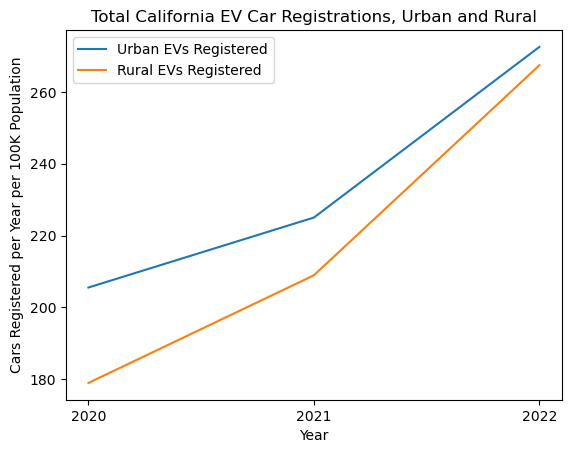

<Figure size 640x480 with 0 Axes>

In [25]:
# Let's try plotting the adoption rate for the entire state of EV's
# as a line chart, separating out the number of car registrations into rural vs. urban areas
#
# Rather than just looking at the totals, a more interesting comparison is to look at 
# The number of cars registered per hundred thousand people, otherwise we will just see
# higher numbers for urban regions because they are the majority of the population, when what
# we really want are the comparative rates of adoption, so the 'y' axis is effectively
# normalized for both urban and rural--a true rate.

ax = aggregated_urban['Vehicles per 100K'].plot(xticks=aggregated_rural.index,
                                    title='Total California EV Car Registrations, Urban and Rural',
                                   )
aggregated_rural['Vehicles per 100K'].plot(ax = ax, xticks=aggregated_rural.index)
plt.legend(["Urban EVs Registered", "Rural EVs Registered"])
plt.ylabel('Cars Registered per Year per 100K Population')
title='Total California EV Car Registrations, Urban and Rural'
plt.show()

plt.savefig('Resources/Car_Registrations_Urban_v_Rural.jpg')